In [1]:
import gym
import custom_robotics
import wrappers
from custom_policies import custom_feature_extractor

from stable_baselines3 import SAC#, HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import numpy as np

In [2]:
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": int(2e6),
    "env_name": "CustomFetchReach-v0",
    "name": "SAC_late_fusion_large_target",
    "learning_starts": 10000,
    "buffer_size": 100000,
    "gamma": 0.95,
    "learning_rate": 0.001,
    "normalize": True,
    "noise": "OrnsteinUhlenbeckActionNoise",
    "mean": 0,
    "sigma": 0.1,
    "imageSize": 100
}
base_folder = "fetch-reach"

In [3]:
def make_env():
    env = gym.make(config["env_name"])
    env = Monitor(env)  # record stats such as returns
    env = wrappers.ImageAndRobot(env, config["imageSize"], config["imageSize"])
    env = wrappers.FrameStack(env, stack_size=4, use_3d_conv=False, add_robot=True)
    return env
env = DummyVecEnv([make_env])

In [8]:
model = SAC(config["policy_type"], env, 
    learning_starts=1000, 
    buffer_size=config["buffer_size"],
    gamma=config["gamma"],
    learning_rate=config["learning_rate"],
    policy_kwargs=dict(
        features_extractor_class=custom_feature_extractor.CustomFeatureExtractor,
        features_extractor_kwargs=dict(custom_cnn=False),
        net_arch=[512, 256]
    ),
    action_noise=OrnsteinUhlenbeckActionNoise(np.zeros(shape=4) + config["mean"], np.zeros(shape=4) + config["sigma"]),
    verbose=1)
model.learn(
    total_timesteps=config["total_timesteps"],
)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.8    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 602      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -49.4    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 604      |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.8    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 12     

KeyboardInterrupt: 

In [5]:
name = config["name"]
run = wandb.init(
    project="fetch-reach",
    entity="f-krone",
    name=name,
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


env = VecVideoRecorder(env, f"videos/{base_folder}/{name}_{run.id}", record_video_trigger=lambda x: x % 2000 == 0, video_length=200)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: f-krone (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
model = SAC(config["policy_type"], env, 
    learning_starts=config["learning_starts"], 
    buffer_size=config["buffer_size"],
    gamma=config["gamma"],
    learning_rate=config["learning_rate"],
    policy_kwargs=dict(
        features_extractor_class=custom_feature_extractor.CustomFeatureExtractor,
        features_extractor_kwargs=dict(custom_cnn=False),
        net_arch=[512, 512]
    ),
    verbose=1, tensorboard_log=f"runs/{base_folder}/{name}_{run.id}")
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=100,
        model_save_path=f"models/{base_folder}/{name}_{run.id}",
        verbose=2,
    ),
)
model.save(f"{name}_{base_folder}")

Using cuda device
Logging to runs/fetch-reach/SAC_late_fusion_large_target_bzyldghe/SAC_1
Saving video to /home/ws/upecj/master/models/src/videos/fetch-reach/SAC_late_fusion_large_target_bzyldghe/rl-video-step-0-to-step-200.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 103      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.5    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 175      |
|    time_elapsed    | 2        |
|    total_timesteps | 400      |
---------------------------------
------------------------

In [7]:
run.finish()
model.save(f"{name}_{base_folder}")

global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▃█▇▄▅▆▆▄▂▂▂▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/success_rate,▁▁▁▁▅▅▅█▅▁▁▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▆▇███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/actor_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█
train/critic_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train/ent_coef,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█
train/ent_coef_loss,▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,87400


In [15]:
video_folder = 'logs/videos/'
video_length = 500
env_id=config["env_name"]
name = "SAC_multiInput_custom"

test_env = DummyVecEnv([make_env])

# Record the video starting at the first step
test_env = VecVideoRecorder(test_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"{name}-{env_id}")
obs = test_env.reset()
test_model = SAC.load(f"{name}_fetch", env=test_env)

for _ in range(video_length + 1):
  action, _states = test_model.predict(obs, deterministic=True)
  obs, _, _, _ = test_env.step(action)
# Save the video
test_env.close()

Saving video to /home/ws/upecj/master/models/logs/videos/SAC_multiInput_custom-CustomFetchPickAndPlaceDense-v0-step-0-to-step-500.mp4


Error: You must call wandb.init() before wandb.log()

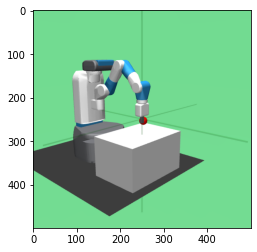

In [4]:
import matplotlib.pyplot as plt

img = env.render(mode="rgb_array")
plt.imshow(img)